In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
import random
from torch import nn

# Constants
SEED = 123
IMG_SIZE = 224
BATCH_SIZE = 64
LEARNING_RATE = 3e-5
EPOCHS = 1000
NUM_CLASSES = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label
    
def create_transforms():
    # Create transform pipeline manually
    train_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]) 

    # Create transform pipeline manually
    test_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return train_transforms, test_transforms

def load_and_split_data(data_path):
    data = pd.read_csv(data_path)
    data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=SEED)
    data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=SEED)
    return data_train, data_val, data_test

def create_datasets(data_train, data_val, data_test, train_transforms, test_transforms):
    train_dataset = FERDataset(data_train, transform=train_transforms)
    val_dataset = FERDataset(data_val, transform=test_transforms)
    test_dataset = FERDataset(data_test, transform=test_transforms)
    return train_dataset, val_dataset, test_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             generator=torch.Generator().manual_seed(SEED))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           generator=torch.Generator().manual_seed(SEED))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                            generator=torch.Generator().manual_seed(SEED))
    return train_loader, val_loader, test_loader

class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x
    
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output
    
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0., # Dropout for attention projection
                 mlp_dropout:float=0., # Dropout for dense/MLP layers 
                 embedding_dropout:float=0., # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
         
        self.num_patches = (img_size * img_size) // patch_size**2
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = torch.cat((class_token, x), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.norm(x)
        
        cls_token_final = x[:, 0]

        logits = self.head(cls_token_final)

        return logits

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop
    
    
def train_model(model, train_loader, val_loader):
    # Initialize training utilities
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    early_stopping = EarlyStopping(patience=10, min_delta=0)

    # Define path
    SAVE_PATH = "E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix"
    os.makedirs(SAVE_PATH, exist_ok=True)

    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Initialize the best metric for model saving
    best_val_accuracy = -float('inf')

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                "Acc": f"{correct / total:.4f}"
            })

        # Calculate training accuracy and loss
        train_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Print training summary
        print(f"Epoch {epoch + 1}/{EPOCHS}: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print validation summary
        print(f"Epoch {epoch + 1}/{EPOCHS}: "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}, "
              f"Val F1: {val_f1:.4f}")

        # Step the learning rate scheduler based on validation loss
        scheduler.step(avg_val_loss)

        # Print the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model_path = os.path.join(SAVE_PATH, "vit_scratch_woAugment_best.pt")
            torch.save({
                "model_state_dict": model.state_dict()
            }, model_path)
    #         torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

        # Save loss and accuracy plots
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        loss_plot_path = os.path.join(SAVE_PATH, "vit_scratch_woAugment_loss.png")
        plt.savefig(loss_plot_path)
        plt.close()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
        plt.title("Accuracy per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        accuracy_plot_path = os.path.join(SAVE_PATH, "vit_scratch_woAugment_accuracy.png")
        plt.savefig(accuracy_plot_path)
        plt.close()
        
        if early_stopping(avg_val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}!")
            break

def evaluate_model(best_model, test_loader):
    criterion = nn.CrossEntropyLoss()
    best_model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(test_loader, desc="Testing")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = best_model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                "Acc": f"{test_correct / test_total:.4f}"
            })

    # Calculate test accuracy, loss, and F1-score
    test_accuracy = test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)
    test_f1 = f1_score(all_targets, all_predicted, average="weighted")

    # Calculate per-class accuracy
    conf_matrix = confusion_matrix(all_targets, all_predicted)
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

    # Calculate classification report (includes precision, recall, F1-score, and support)
    class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

    # Print test summary
    print(f"Test Loss: {avg_test_loss:.4f}, "
          f"Test Acc: {test_accuracy:.4f},"
          f"Test F1: {test_f1:.4f}")

    # Print per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"Class {i}: {acc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(class_report)

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {DEVICE}")
    print(f"PyTorch version: {torch.__version__}")

    # Data preparation
    train_transforms, test_transforms = create_transforms()
    data_train, data_val, data_test = load_and_split_data("E://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013v2_clean.csv")
    train_dataset, val_dataset, test_dataset = create_datasets(data_train, data_val, data_test, train_transforms, test_transforms)
    
    train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    model = ViT(num_classes=len(class_names), 
                in_channels=3, 
                patch_size=32, 
                num_heads=12, 
                embedding_dim=768, 
                num_transformer_layers=12,
                mlp_size=3072)
    model.to(DEVICE)
    
    train_model(model, train_loader, val_loader)
    
    best_model = ViT(num_classes=len(class_names), 
                     in_channels=3, 
                     patch_size=32, 
                     num_heads=12, 
                     embedding_dim=768, 
                     num_transformer_layers=12,
                     mlp_size=3072)
    best_model = best_model.to(DEVICE)
    
    checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix//vit_scratch_woAugment_best.pt")
    best_model.load_state_dict(checkpoint["model_state_dict"])
    
    evaluate_model(best_model, test_loader)

if __name__ == "__main__":
    main()

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Using device: cuda
PyTorch version: 2.5.0+cu124


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [03:50<00:00,  1.83it/s, Loss=1.7331, Acc=0.2954]


Epoch 1/1000: Train Loss: 1.7331, Train Acc: 0.2954


Epoch 1/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:11<00:00,  4.03it/s, Loss=1.6757, Acc=0.3302]


Epoch 1/1000: Val Loss: 1.6757, Val Acc: 0.3302, Val F1: 0.2293
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.3302


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [04:59<00:00,  1.41it/s, Loss=1.5801, Acc=0.3873]


Epoch 2/1000: Train Loss: 1.5801, Train Acc: 0.3873


Epoch 2/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:11<00:00,  3.93it/s, Loss=1.5440, Acc=0.4026]


Epoch 2/1000: Val Loss: 1.5440, Val Acc: 0.4026, Val F1: 0.3958
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4026


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [05:01<00:00,  1.40it/s, Loss=1.5082, Acc=0.4164]


Epoch 3/1000: Train Loss: 1.5082, Train Acc: 0.4164


Epoch 3/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:12<00:00,  3.74it/s, Loss=1.4764, Acc=0.4360]


Epoch 3/1000: Val Loss: 1.4764, Val Acc: 0.4360, Val F1: 0.4139
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4360


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [04:59<00:00,  1.41it/s, Loss=1.4514, Acc=0.4375]


Epoch 4/1000: Train Loss: 1.4514, Train Acc: 0.4375


Epoch 4/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:11<00:00,  4.06it/s, Loss=1.4583, Acc=0.4363]


Epoch 4/1000: Val Loss: 1.4583, Val Acc: 0.4363, Val F1: 0.4286
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4363


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [05:01<00:00,  1.40it/s, Loss=1.3834, Acc=0.4672]


Epoch 5/1000: Train Loss: 1.3834, Train Acc: 0.4672


Epoch 5/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:10<00:00,  4.31it/s, Loss=1.4459, Acc=0.4460]


Epoch 5/1000: Val Loss: 1.4459, Val Acc: 0.4460, Val F1: 0.4497
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4460


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [04:30<00:00,  1.56it/s, Loss=1.3166, Acc=0.4979]


Epoch 6/1000: Train Loss: 1.3166, Train Acc: 0.4979


Epoch 6/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:10<00:00,  4.51it/s, Loss=1.4144, Acc=0.4686]


Epoch 6/1000: Val Loss: 1.4144, Val Acc: 0.4686, Val F1: 0.4461
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4686


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [04:26<00:00,  1.58it/s, Loss=1.2266, Acc=0.5366]


Epoch 7/1000: Train Loss: 1.2266, Train Acc: 0.5366


Epoch 7/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:11<00:00,  4.10it/s, Loss=1.4117, Acc=0.4643]


Epoch 7/1000: Val Loss: 1.4117, Val Acc: 0.4643, Val F1: 0.4653
Current Learning Rate: 3e-05


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [04:27<00:00,  1.58it/s, Loss=1.1065, Acc=0.5850]


Epoch 8/1000: Train Loss: 1.1065, Train Acc: 0.5850


Epoch 8/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:10<00:00,  4.41it/s, Loss=1.4746, Acc=0.4483]


Epoch 8/1000: Val Loss: 1.4746, Val Acc: 0.4483, Val F1: 0.4569
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [04:27<00:00,  1.58it/s, Loss=0.9222, Acc=0.6537]


Epoch 9/1000: Train Loss: 0.9222, Train Acc: 0.6537


Epoch 9/1000 (Validation): 100%|██████████████████████████████| 47/47 [00:10<00:00,  4.34it/s, Loss=1.5783, Acc=0.4787]


Epoch 9/1000: Val Loss: 1.5783, Val Acc: 0.4787, Val F1: 0.4742
Current Learning Rate: 3e-05
Best model saved at E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix\vit_scratch_woAugment_best.pt with val accuracy: 0.4787


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [04:27<00:00,  1.58it/s, Loss=0.6817, Acc=0.7469]


Epoch 10/1000: Train Loss: 0.6817, Train Acc: 0.7469


Epoch 10/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.38it/s, Loss=1.7735, Acc=0.4743]


Epoch 10/1000: Val Loss: 1.7735, Val Acc: 0.4743, Val F1: 0.4606
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [04:25<00:00,  1.59it/s, Loss=0.4136, Acc=0.8509]


Epoch 11/1000: Train Loss: 0.4136, Train Acc: 0.8509


Epoch 11/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.56it/s, Loss=2.1198, Acc=0.4613]


Epoch 11/1000: Val Loss: 2.1198, Val Acc: 0.4613, Val F1: 0.4611
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [04:26<00:00,  1.59it/s, Loss=0.2287, Acc=0.9209]


Epoch 12/1000: Train Loss: 0.2287, Train Acc: 0.9209


Epoch 12/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.49it/s, Loss=2.3718, Acc=0.4713]


Epoch 12/1000: Val Loss: 2.3718, Val Acc: 0.4713, Val F1: 0.4669
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [04:25<00:00,  1.59it/s, Loss=0.1405, Acc=0.9527]


Epoch 13/1000: Train Loss: 0.1405, Train Acc: 0.9527


Epoch 13/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:11<00:00,  4.06it/s, Loss=2.7511, Acc=0.4640]


Epoch 13/1000: Val Loss: 2.7511, Val Acc: 0.4640, Val F1: 0.4593
Current Learning Rate: 3e-06


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [04:26<00:00,  1.59it/s, Loss=0.0417, Acc=0.9897]


Epoch 14/1000: Train Loss: 0.0417, Train Acc: 0.9897


Epoch 14/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.59it/s, Loss=2.8896, Acc=0.4743]


Epoch 14/1000: Val Loss: 2.8896, Val Acc: 0.4743, Val F1: 0.4743
Current Learning Rate: 3e-06


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [04:31<00:00,  1.56it/s, Loss=0.0137, Acc=0.9984]


Epoch 15/1000: Train Loss: 0.0137, Train Acc: 0.9984


Epoch 15/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.44it/s, Loss=3.0170, Acc=0.4690]


Epoch 15/1000: Val Loss: 3.0170, Val Acc: 0.4690, Val F1: 0.4703
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [04:31<00:00,  1.56it/s, Loss=0.0089, Acc=0.9989]


Epoch 16/1000: Train Loss: 0.0089, Train Acc: 0.9989


Epoch 16/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.33it/s, Loss=3.1214, Acc=0.4693]


Epoch 16/1000: Val Loss: 3.1214, Val Acc: 0.4693, Val F1: 0.4690
Current Learning Rate: 3e-06


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [04:28<00:00,  1.57it/s, Loss=0.0068, Acc=0.9992]


Epoch 17/1000: Train Loss: 0.0068, Train Acc: 0.9992


Epoch 17/1000 (Validation): 100%|█████████████████████████████| 47/47 [00:10<00:00,  4.56it/s, Loss=3.1902, Acc=0.4723]


Epoch 17/1000: Val Loss: 3.1902, Val Acc: 0.4723, Val F1: 0.4728
Current Learning Rate: 3e-06
Early stopping triggered at epoch 17!


C:\Users\MoKha\AppData\Local\Temp\ipykernel_27744\1114801901.py:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasi

Test Loss: 1.5605, Test Acc: 0.4734,Test F1: 0.4667

Per-Class Accuracy:
Class 0: 0.2402
Class 1: 0.1778
Class 2: 0.3418
Class 3: 0.6571
Class 4: 0.3687
Class 5: 0.4952
Class 6: 0.6000

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.24      0.31       458
     Class 1       0.47      0.18      0.26        45
     Class 2       0.36      0.34      0.35       471
     Class 3       0.62      0.66      0.64       872
     Class 4       0.37      0.37      0.37       575
     Class 5       0.68      0.50      0.57       315
     Class 6       0.40      0.60      0.48       595

    accuracy                           0.47      3331
   macro avg       0.48      0.41      0.43      3331
weighted avg       0.48      0.47      0.47      3331



Testing: 100%|████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.16it/s, Loss=1.5605, Acc=0.4734]


Test Loss: 1.5605, Test Acc: 0.4734,Test F1: 0.4667

Per-Class Accuracy:
Class 0: 0.2402
Class 1: 0.1778
Class 2: 0.3418
Class 3: 0.6571
Class 4: 0.3687
Class 5: 0.4952
Class 6: 0.6000

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.24      0.31       458
     Class 1       0.47      0.18      0.26        45
     Class 2       0.36      0.34      0.35       471
     Class 3       0.62      0.66      0.64       872
     Class 4       0.37      0.37      0.37       575
     Class 5       0.68      0.50      0.57       315
     Class 6       0.40      0.60      0.48       595

    accuracy                           0.47      3331
   macro avg       0.48      0.41      0.43      3331
weighted avg       0.48      0.47      0.47      3331



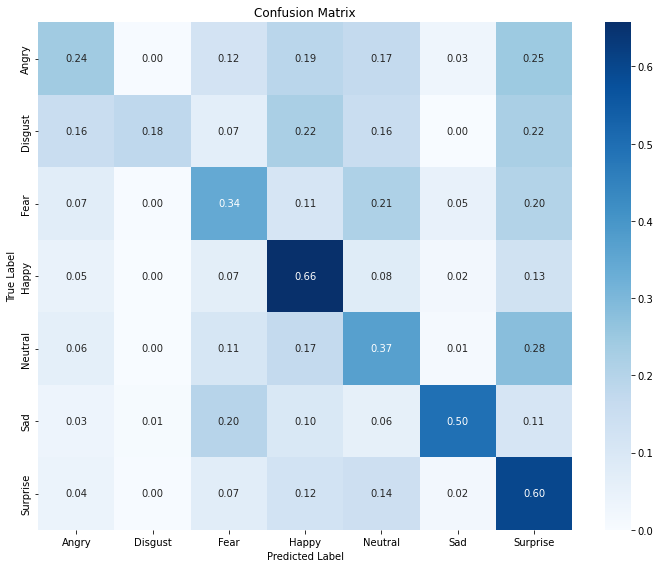

In [16]:
evaluate_model(best_model, test_loader)